In [424]:
from keras.models import Sequential
import matplotlib.pyplot as plt
from PIL import Image
import glob 
import numpy as np 
import cv2
import os
from skimage.transform import resize


<h1>Show Sample Training Image</h1>

sample image:  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x1AD9E6128>
sample image type:  <class 'PIL.JpegImagePlugin.JpegImageFile'>
numpy shape:  (250, 250, 3)


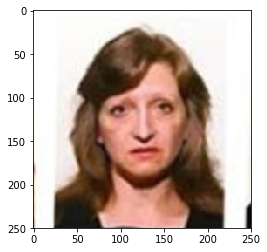

In [425]:
# using scikit image
im = Image.open('data/training_images/train_img_1.jpg')
print("sample image: ", im)
print("sample image type: ",type(im))
plt.imshow(im)

# after converting it into numpy array
sample_train = np.array(im) # convert to JpegImage to numpy array
print("numpy shape: ", sample_train.shape)

sample image type:  <class 'numpy.ndarray'>
sample image shape:  (250, 250, 3)


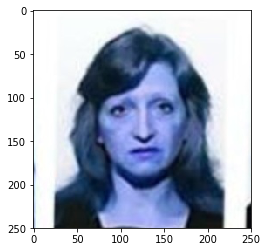

In [426]:
# Using Opencv2: it reads the image as numpy
imO = cv2.imread('data/training_images/train_img_1.jpg') # store as numpy
print("sample image type: ", type(imO))
print("sample image shape: ", imO.shape)
# OpenCV represents RGB images as multi-dimensional NumPy arrays…but in reverse order!
# So numpy array read by OpenCV is BGR...
plt.imshow(imO)  # Display BGR... no good 

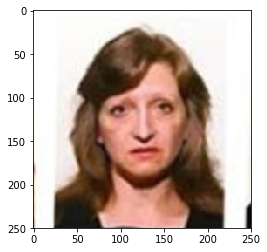

In [427]:
plt.imshow(cv2.cvtColor(imO, cv2.COLOR_BGR2RGB)) # now RGB! 

<h1>Store Train Images in List</h1>

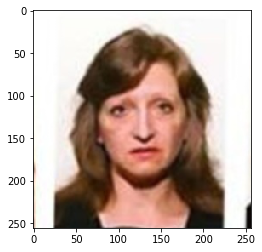

In [429]:
image_list = []
IMG_HEIGHT = 256
IMG_WIDTH = 256
train_image_path = 'data/training_images/'
for i in range(1, 1501):
    im = cv2.imread(train_image_path + 'train_img_' + str(i) + '.jpg') # read as numpy
    # resize the image to 256 X 256
    im = cv2.resize(im,(IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    image_list.append(im) # append it to the list 
plt.imshow(cv2.cvtColor(image_list[0], cv2.COLOR_BGR2RGB)) # display the first image

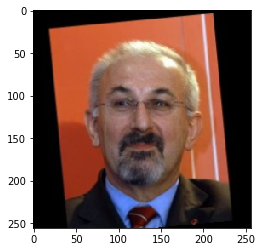

In [430]:
plt.imshow(cv2.cvtColor(image_list[1499], cv2.COLOR_BGR2RGB)) # display the last image

<h1>Get Image_List Info</h1>

In [431]:
print("image_list length: ", len(image_list), "; index[0] - index[1499])")
print("each numpy array in list shape: ", image_list[0].shape)

image_list length:  1500 ; index[0] - index[1499])
each numpy array in list shape:  (256, 256, 3)


<h1>Store Train Masks in List</h1>

In [432]:
mask_list = []
IMG_HEIGHT = 256
IMG_WIDTH = 256
train_mask_path = 'data/training_masks/'
for i in range(1, 1501):
    # opencv reads an image as 3 Channles (BGR) although mask is a grayscale image
    im = cv2.imread(train_mask_path + 'train_mask_' + str(i) + '.jpg') # read as numpy
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # convert BGR to Grayscale
    # resize the image to 256 X 256
    im = cv2.resize(im,(IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    # expand dimension (256, 256) to (256, 256, 1) to indicate that it has 1 channel for model.fit
    im = np.expand_dims(im, 2) # 2 indicates 3rd dimension
    mask_list.append(im) # append it to the list 

(256, 256, 1)


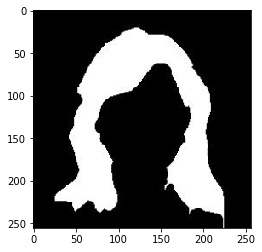

In [433]:
print (mask_list[0].shape)
# squeeze changes (256, 256, 1) to (256, 256)
# plt. imshow accepts Parameters: (n, m) or (n, m, 3) or (n, m, 4)
# So it does not accpet (n, m, 1)
plt.imshow( np.squeeze(mask_list[0]),cmap='gray' ) # display the first image

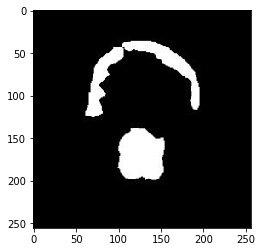

In [434]:
plt.imshow(np.squeeze(mask_list[1499]), cmap='gray') # display the last image

<h1>Get Mask_List Info</h1>
<p>Mask is a grayscale image. It only has 1 channel</p>

In [435]:
print("image_list length: ", len(mask_list), "; index[0] - index[1499])")
print("each numpy array in list shape: ", mask_list[0].shape)

image_list length:  1500 ; index[0] - index[1499])
each numpy array in list shape:  (256, 256, 1)


<h1>Add Validaion Data to Train Data</h1>
<p>It is easier to just slipt train data to validation data than manage train set and validation set. If you want to use validation set separately for model.fit, you need to do do model.fit(validation_data = (x_val , y_val) ) # tuple of x val and y val</p>

In [436]:
val_img_path = 'data/validation_images/'
for i in range(1, 501):
    im = cv2.imread(val_img_path + 'validation_img_' + str(i) + '.jpg') # read as numpy
    # resize the image to 256 X 256
    im = cv2.resize(im,(IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    image_list.append(im) # append it to the list 


1500


2000


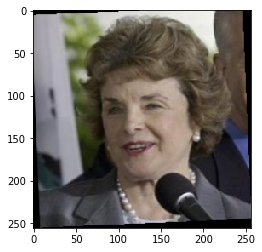

In [437]:
# Display the first validation image
print(len(image_list))
plt.imshow(cv2.cvtColor(image_list[1500], cv2.COLOR_BGR2RGB)) # display the first image

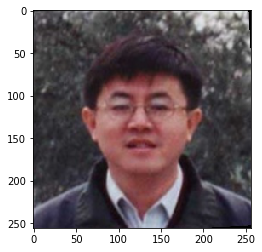

In [444]:
# Display the last validation image
plt.imshow(cv2.cvtColor(image_list[1999] , cv2.COLOR_BGR2RGB)) # display the first image

<h1>Create Keras Metric</h1>
<p>It's used for the loss function. It's a customized loss function kind of</p>

In [441]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

<h1>Build U-Net Model</h1>

In [442]:
# Build U-Net Model
def get_unet():
    # Build U-Net model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    model.summary()

In [358]:
# Fit Model